In [1]:
from scipy.io import loadmat
from utils import *
data = loadmat('emnist-digits.mat')
import matplotlib.pyplot as plt
import numpy as np


In [2]:
dataset = data['dataset'][0, 0]
train = dataset[0][0, 0]  
test = dataset[1][0, 0]  
mapping = dataset[2]

train_images = train['images']   # Shape: (N, 28*28)
train_labels = train['labels']  # Shape: (N, 1)
train_writers = train['writers']
X = train_images.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = train_labels.flatten().astype(np.int64)

# Wrap into a datalist with a single client
datalist = [(X, y)]

test_images = test['images'].astype(np.float32) / 255.0
test_labels = test['labels'].flatten().astype(np.int64)

In [3]:
from labels_utils import *

### Baseline 1 : fedAvg with one client holding all the data

In [ ]:

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# Run FedAvg with 1 client
print("now training the baseline, i.e. fedAvg with one client holding all the data")
model = fedavg(datalist, T, K, gamma)


In [15]:
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 84.80%


### Baseline 2 : fedAvg with five clients sharing all the data together, iid between them.

In [18]:
n_clients = 5
beta = 1e5
datalist = create_dirichlet_clients(X, y, n_clients, beta)

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print("case with 5 clients, beta=10^5, which means close to IID clients (baseline 2)!")
model = fedavg(datalist, T, K, gamma)


case with 5 clients, beta=10^5, which means close to IID clients (baseline 2)!
round :  1
round :  2
round :  3
round :  4
round :  5


In [19]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} clients and Dir({beta}): {test_accuracy * 100:.2f}%")

Test Accuracy with 5 clients and Dir(100000.0): 84.07%


#### => Test results are close in between the two baselines: normal since FedAvg reduces to Gradient Descent when data is iid between clients

### Testing FedAvg on different &beta; values for distribution based label shift

Running FedAvg with beta=0.1
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with beta=0.3
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with beta=0.5
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with beta=0.7
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with beta=1.0
round :  1
round :  2
round :  3
round :  4
round :  5


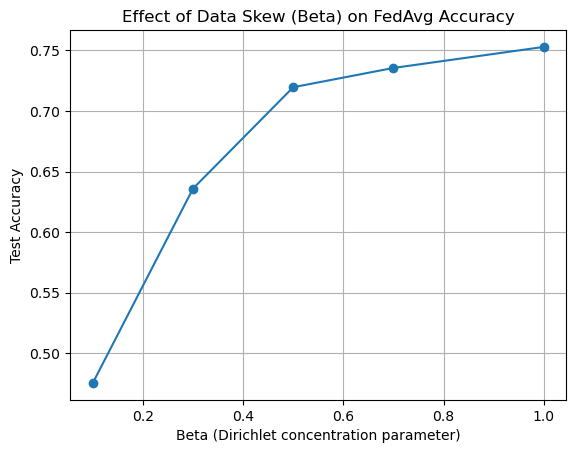

In [4]:
beta_values = [0.1, 0.3, 0.5, 0.7, 1.0]
n_clients = 5
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

accuracies = []

for beta in beta_values:
    print(f"Running FedAvg with beta={beta}")
    datalist = create_dirichlet_clients(X, y, n_clients, beta)
    model = fedavg(datalist, T, K, gamma)
    acc = evaluate(model, test_images, test_labels)
    accuracies.append(acc)

# Plotting
plt.figure()
plt.plot(beta_values, accuracies, marker='o')
plt.xlabel('Beta (Dirichlet concentration parameter)')
plt.ylabel('Test Accuracy')
plt.title('Effect of Data Skew (Beta) on FedAvg Accuracy')
plt.grid(True)
plt.show()


In [20]:
n_clients = 5
beta = 0.5 
datalist = create_dirichlet_clients(X, y, n_clients, beta)

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print("case with 5 clients, beta=0.5 skewed distribution, with weights based on the inverse KL-divergence")
weights = compute_inverse_kl_weights(datalist)
model = fedavg(datalist, T=5, K=10, gamma=0.1, weights=weights)


case with 5 clients, beta=0.5 skewed distribution, with weights based on the inverse KL-divergence
round :  1
round :  2
round :  3
round :  4
round :  5


In [21]:
test_accuracy = evaluate(model, test_images, test_labels)
print(test_accuracy)

0.6942750215530396


### Testing FedAvg on different k values for quantity based label shift

Running FedAvg with k=1 classes per client
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with k=2 classes per client
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with k=3 classes per client
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with k=5 classes per client
round :  1
round :  2
round :  3
round :  4
round :  5
Running FedAvg with k=8 classes per client
round :  1
round :  2
round :  3
round :  4
round :  5


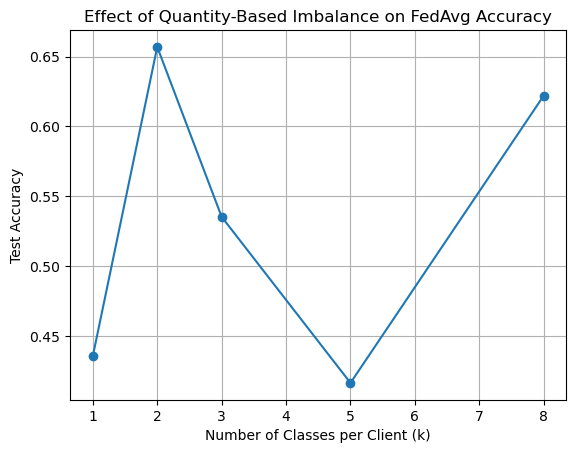

In [4]:
k_values = [1, 2, 3, 5, 8]  # Number of classes per client
n_clients = 5
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

accuracies = []

for k in k_values:
    print(f"Running FedAvg with k={k} classes per client")
    datalist = create_quantity_imbalanced_clients(X, y, n_clients, k)
    model = fedavg(datalist, T, K, gamma)
    acc = evaluate(model, test_images, test_labels)
    accuracies.append(acc)

# Plotting
plt.figure()
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Classes per Client (k)')
plt.ylabel('Test Accuracy')
plt.title('Effect of Quantity-Based Imbalance on FedAvg Accuracy')
plt.grid(True)
plt.show()


### Testing the Moon Federated learning on the same &beta; list

In [26]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [7]:
n_clients = 5
beta = 0.5 
datalist = create_dirichlet_clients(X, y, n_clients, beta)

In [8]:
model, loss_curve = fedavg_moon(datalist, T=5, K=10, gamma=0.1, mu=0.5)


In [9]:
test_accuracy = evaluate(model, test_images, test_labels)
print(test_accuracy)

0.8220999765396118


Running FedAvg-MOON with beta=0.1
Running FedAvg-MOON with beta=0.3
Running FedAvg-MOON with beta=0.5
Running FedAvg-MOON with beta=0.7
Running FedAvg-MOON with beta=1.0


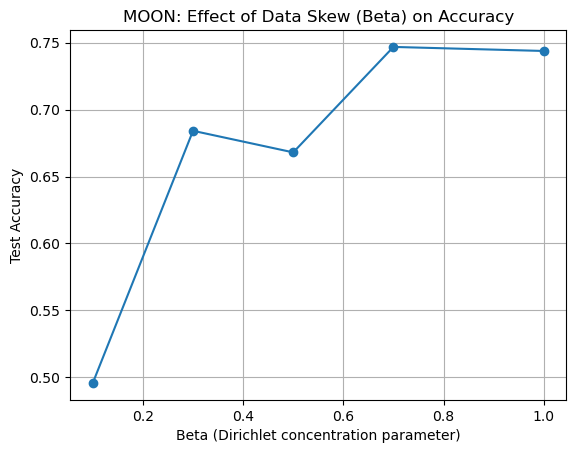

In [6]:
# Hyperparameters
n_clients = 5
T = 5       # number of global rounds
K = 10      # number of local steps
gamma = 0.1 # learning rate
mu = 0.5    # contrastive loss coefficient (specific to MOON)

# Different beta values to simulate various degrees of data skew
beta_values = [0.1, 0.3, 0.5, 0.7, 1.0]
accuracies = []

for beta in beta_values:
    print(f"Running FedAvg-MOON with beta={beta}")
    datalist = create_dirichlet_clients(X, y, n_clients, beta)
    model, loss_curve = fedavg_moon(datalist, T=T, K=K, gamma=gamma, mu=mu)
    acc = evaluate(model, test_images, test_labels)
    accuracies.append(acc)

# Plotting accuracy vs. beta
plt.figure()
plt.plot(beta_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Beta (Dirichlet concentration parameter)')
plt.ylabel('Test Accuracy')
plt.title('MOON: Effect of Data Skew (Beta) on Accuracy')
plt.grid(True)
plt.show()